Lets do this in 2D, we want to look at orbital motion

In [1]:
#include the usuals
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math as math
from matplotlib.animation import FuncAnimation
plt.style.use('seaborn-pastel')

/Users/pharris/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In this scenario, we want to make a 2D simulation of orbits. For this, all we have is the gravitational force. Later on the class, we will work out a parametrization in the center of mass frame that makes the problem a bit simpler. However for now lets just brute force it. Consider two bodies, the force on each other can be written as 
\begin{eqnarray}
M_{1}\frac{d^2\vec{x_1}}{dt^2} & = & G\frac{M_{1}M_{2}}{r^2}\hat{r}\\
M_{2}\frac{d^2\vec{x_2}}{dt^2} & = & -G\frac{M_{1}M_{2}}{r^2}\hat{r}
\end{eqnarray}
This we can then translate this to a vectorized update following the form that we have previously used. 
\begin{eqnarray}
\vec{x}=\vec{x_{0}} + \vec{v_{0}} \delta t + \frac{1}{2} \vec{a}\delta t^2
\end{eqnarray}
Lets write out our force and a 2D iterator. As a first pass we will brute force it. 

In [23]:
def gravity(iM1,iM2,iX1,iY1,iX2,iY2):
    #For my own sanity, we will put the 0.001 to avoid infinities. 
    #Also we will set G = to 1
    pR2=(iX1-iX2)*(iX1-iX2)+(iY1-iY2)*(iY1-iY2)+0.001
    FR=-iM2/pR2
    #Get the X and Y projections
    pX=(iX1-iX2)/math.sqrt(pR2)
    pY=(iY1-iY2)/math.sqrt(pR2)
    return FR*pX,FR*pY

def grav_array(iM1=1,iM2=1,iDT=0.001,iN=20000):
    #To start with we will just do 2 objects, 1 and 2
    t=[]
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    #Now lets define the initial conditions
    dt=iDT
    #Lets put them symmetrically about 0 and give them perpendicular motion
    x1_old = [ 0,1]
    x2_old = [ 0,-1]
    v1_old = [-0.25,0]
    v2_old = [ 0.25,0]
    for i0 in range(iN):
        pT=i0*dt
        #update 1
        dX1,dY1=gravity(iM1,iM2,x1_old[0],x1_old[1],x2_old[0],x2_old[1])
        v1_old[0]=v1_old[0]+dt*dX1
        v1_old[1]=v1_old[1]+dt*dY1
        x1_old[0]=x1_old[0]+dt*v1_old[0]+0.5*dt*dt*dX1
        x1_old[1]=x1_old[1]+dt*v1_old[1]+0.5*dt*dt*dY1

        #update 2
        dX2,dY2=gravity(iM2,iM1,x2_old[0],x2_old[1],x1_old[0],x1_old[1])
        v2_old[0]=v2_old[0]+dt*dX2
        v2_old[1]=v2_old[1]+dt*dY2
        x2_old[0]=x2_old[0]+dt*v2_old[0]+0.5*dt*dt*dX2
        x2_old[1]=x2_old[1]+dt*v2_old[1]+0.5*dt*dt*dY2

        #fill arryas
        t.append(pT)
        x1.append(x1_old[0])
        x2.append(x2_old[0])
        y1.append(x1_old[1])
        y2.append(x2_old[1])
    return t,x1,y1,x2,y2

<IPython.core.display.Javascript object>


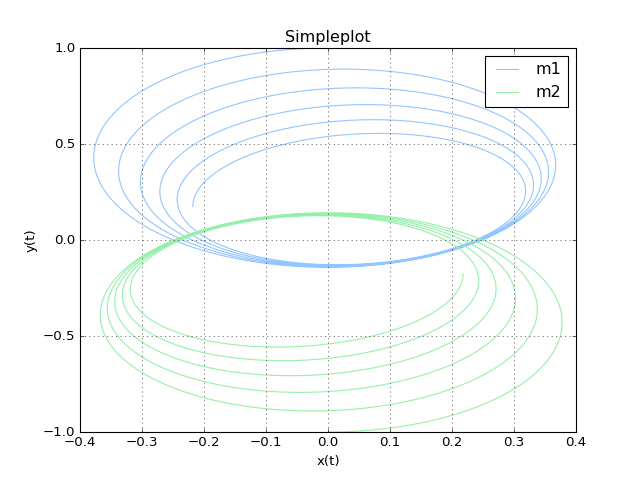

In [24]:
fig, ax = plt.subplots()
tout1,xout1,yout1,xout2,yout2=grav_array()
ax.plot(xout1,yout1,label='m1')
ax.plot(xout2,yout2,label='m2')
ax.set(xlabel='x(t)', ylabel='y(t)',title='Simpleplot')
ax.grid()
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


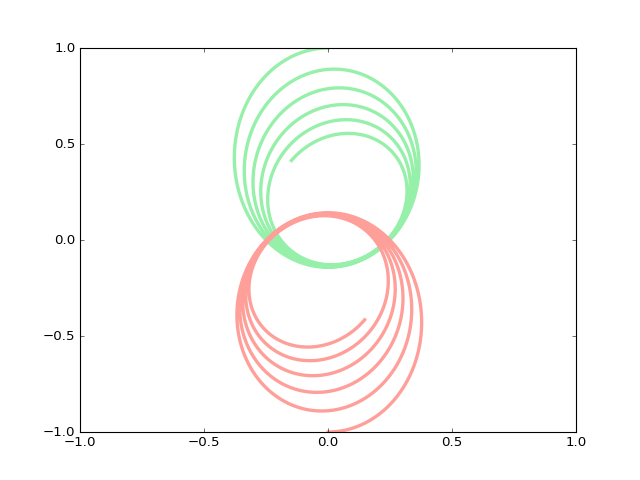

In [26]:
#now lets animate it
fig = plt.figure()
ax = plt.axes(xlim=(-1, 1), ylim=(-1, 1))
line, = ax.plot([], [], lw=3)
lines = []
Nbody=2
for index in range(Nbody):
    lobj = ax.plot([],[],lw=3,)[0]
    lines.append(lobj)

def init():
    for line in lines:
        line.set_data([],[])
    return lines


def animate(i):
    line_x1 = xout1[0:i]
    line_y1 = yout1[0:i]
    line_x2 = xout2[0:i]
    line_y2 = yout2[0:i]
    lines[0].set_data(line_x1,line_y1)
    lines[1].set_data(line_x2,line_y2)
    return lines

anim = FuncAnimation(fig, animate, init_func=init,frames=20000, interval=1, blit=True)

Now we want to generalize this to an arbitrary number of planets. To do this we can do this using numpy array opertions. Before we go do this, lets introduce a few basic concepts. To do that lets maake 2-vecotr arrays and add them and play with them. 


In [27]:
#Lets deinfe a simple 2 vector
X=np.array([1,1])
print(X,X.shape)
#now we add another two vector to it
X=np.append(X,[2,2])
print(X,X.shape)
#Crap! its one vector of 4 elements and not 2 of 2, lets fix that
X=np.reshape(X, (2, 2))
print(X,X.shape)
#now lets add
a=np.add(X[0],X[1])
print(a)
#now lets add aadd and scale
b=np.add(X[0],X[1]*0.1)
print(b)
#hooray!

(array([1, 1]), (2,))
(array([1, 1, 2, 2]), (4,))
(array([[1, 1],
       [2, 2]]), (2, 2))
[3 3]
[ 1.2  1.2]


In [28]:
#ok now lets redefinei our gravitational force with vectors (its pretty much the same)
def gravityvec(iM1,iM2,iX1,iX2):
    pR2=(iX1[0]-iX2[0])*(iX1[0]-iX2[0])+(iX1[1]-iX2[1])*(iX1[1]-iX2[1])+0.001
    FR=-iM2/pR2
    #Get the X and Y projections
    pX=(iX1[0]-iX2[0])/math.sqrt(pR2)
    pY=(iX1[1]-iX2[1])/math.sqrt(pR2)
    out = np.array([FR*pX,FR*pY])
    return out


In [56]:
#Now finally we write out an iterator
#Lets define the initial conditions for Nbodies by random sampling masses and coordinates 
def initial_cond(iM1,Nbody):
    M=[]
    X=[]
    V=[]
    x1=[]
    y1=[]
    for body in range(Nbody):
        mass=iM1*np.random.random((1,1))[0][0]
        M.append(mass)
        xcoord = np.random.random((1,2)) 
        #The V is from some playing around
        vcoord = np.random.random((1,2))*0.0001
        X=np.append(X,xcoord)
        V=np.append(V,vcoord)
        #now we need to setup the x and y arrays
        x1arr=[xcoord[0,0]]
        y1arr=[xcoord[0,1]]
        x1.append(x1arr)
        y1.append(y1arr)

    X=np.reshape(X,(Nbody,2))
    V=np.reshape(V,(Nbody,2))
    return M,X,V,x1,y1

def grav_array(iNbody,iM1=1,iDT=0.0001,iN=5000):
    #Step
    dt=iDT 
    #Number of bodies
    Nbody=iNbody
    #outputs
    t=[]
    M,X,V,x1,y1=initial_cond(iM1,iNbody)
    for i0 in range(iN):
        pT=i0*dt
        t.append(pT)
        for body1 in range(Nbody):
            for body2 in range(Nbody):
                dX=gravityvec(M[body1],M[body2],X[body1],X[body2])
                V[body1]=V[body1]+dt*dX
                X[body1]=X[body1]+dt*V[body1]+0.5*dt*dt*dX        
            x1[body1].append(X[body1,0])
            y1[body1].append(X[body1,1])
    return t,x1,y1

<IPython.core.display.Javascript object>


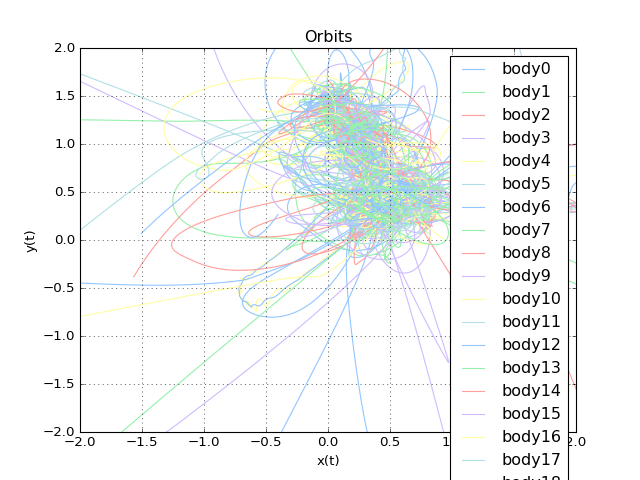

In [74]:
#Now we plot, lets start with 5
fig, ax = plt.subplots()
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
ax.set(xlabel='x(t)', ylabel='y(t)',title='Orbits')
ax.grid()

Nbody=50
tout,xout,yout=grav_array(Nbody)
for body in range(Nbody):
    ax.plot(xout[body],yout[body],label='body'+str(body))
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


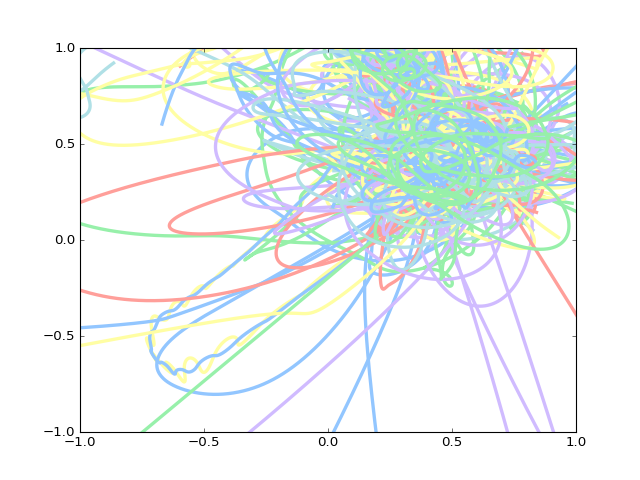

In [77]:
#now lets animate it
#now lets animate it
fig_arr = plt.figure()
ax_arr = plt.axes(xlim=(-1, 1), ylim=(-1, 1))
lines_arr = []
for index in range(Nbody):
    lobj = ax_arr.plot([],[],lw=3,)[0]
    lines_arr.append(lobj)

def init_arr():
    for line in lines_arr:
        line.set_data([],[])
    return lines_arr

def animate_arr(i):
    for body in range(Nbody):
        x = xout[body][1:i]
        y = yout[body][1:i]
        lines_arr[body].set_data(x, y)
    return lines_arr

anim = FuncAnimation(fig_arr, animate_arr, init_func=init_arr,frames=5000, interval=1, blit=True)